# Data Analysis Interview Challenge
- [Part 1](#p1)
- [Part 2](#p2)
- [Part 3](#p3)
    - [EDA](#eda)
    - [Data Transformation](#trans)
    - [Modeling](#model)

In [438]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, RFE, RFECV, SelectFromModel, SequentialFeatureSelector, \
mutual_info_classif
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,\
RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, f1_score
import xgboost as xgb
import optuna

# Part 1 EDA<a id=p1><a>

In [80]:
login = pd.read_json('logins.json')
login

login_time
0     1970-01-01 20:13:18
1     1970-01-01 20:16:10
2     1970-01-01 20:16:37
3     1970-01-01 20:16:36
4     1970-01-01 20:26:21
...                   ...
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23

[93142 rows x 1 columns]

In [4]:
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


No null value.

In [5]:
login.astype('object').describe()

login_time
count                 93142
unique                92265
top     1970-03-17 01:01:39
freq                      3

In [6]:
login.duplicated().sum()

877

There are 877 duplicates, but maybe it is possible that there are ~1000 customers who are login at the
exact same time out of ~100k customers.

Check if the duplicates has different patterns compared to all data.

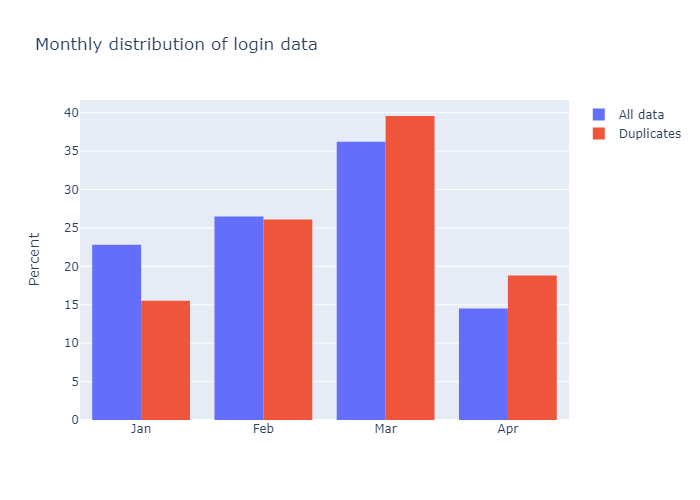

In [82]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=login.login_time.dt.month, histnorm='percent', name='All data'))
fig.add_trace(go.Histogram(x=login.loc[login.duplicated()].login_time.dt.month, histnorm='percent', name='Duplicates'))
fig.update_xaxes(tickmode='array',
    tickvals=np.arange(1,5),
    ticktext=['Jan', 'Feb', 'Mar', 'Apr'])
fig.update_yaxes(title='Percent')
fig.update_layout(title='Monthly distribution of login data')
fig.show('png')

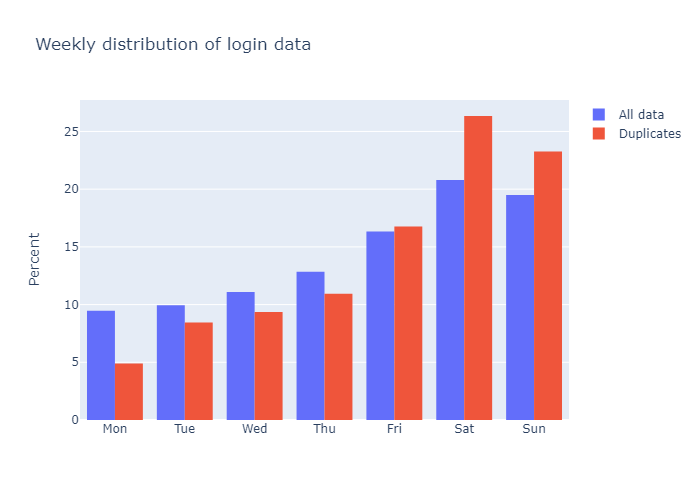

In [83]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=login.login_time.dt.dayofweek, histnorm='percent', name='All data'))
fig.add_trace(go.Histogram(x=login.loc[login.duplicated()].login_time.dt.dayofweek, histnorm='percent', name='Duplicates'))
fig.update_xaxes(tickmode='array',
    tickvals=np.arange(7),
    ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
fig.update_yaxes(title='Percent')
fig.update_layout(title='Weekly distribution of login data')
fig.show('png')

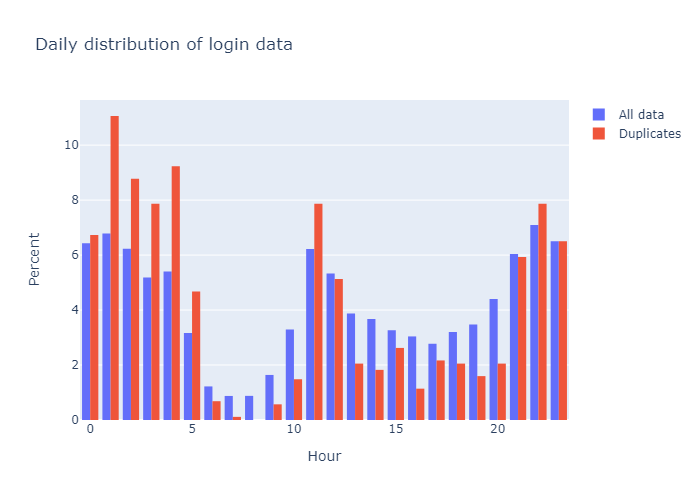

In [84]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=login.login_time.dt.hour, histnorm='percent', name='All data'))
fig.add_trace(go.Histogram(x=login.loc[login.duplicated()].login_time.dt.hour, histnorm='percent', name='Duplicates'))
fig.update_xaxes(title='Hour')
fig.update_yaxes(title='Percent')
fig.update_layout(title='Daily distribution of login data')
fig.show('png')

Duplicated data has similar distribution with the whole data set with a higer percentage between 1-5am.

Thus, assume that they are real and keep them.

In [85]:
login = login.set_index('login_time')

In [86]:
login = login.assign(counts=1)

Aggregate data on 15 min interval

In [87]:
count15m = login.resample('15min').sum()
count15m.head()

counts
login_time                 
1970-01-01 20:00:00       2
1970-01-01 20:15:00       6
1970-01-01 20:30:00       9
1970-01-01 20:45:00       7
1970-01-01 21:00:00       1

In [88]:
count15m['time'] = count15m.index.strftime('%H:%M')
count15m['dayofweek'] = count15m.index.strftime('%a')
count15m['month'] = count15m.index.strftime('%b')

In [89]:
count15m

counts   time dayofweek month
login_time                                        
1970-01-01 20:00:00       2  20:00       Thu   Jan
1970-01-01 20:15:00       6  20:15       Thu   Jan
1970-01-01 20:30:00       9  20:30       Thu   Jan
1970-01-01 20:45:00       7  20:45       Thu   Jan
1970-01-01 21:00:00       1  21:00       Thu   Jan
...                     ...    ...       ...   ...
1970-04-13 17:45:00       5  17:45       Mon   Apr
1970-04-13 18:00:00       5  18:00       Mon   Apr
1970-04-13 18:15:00       2  18:15       Mon   Apr
1970-04-13 18:30:00       7  18:30       Mon   Apr
1970-04-13 18:45:00       6  18:45       Mon   Apr

[9788 rows x 4 columns]

Calculate mean and std of login count for each interval.

In [16]:
avg_15m = count15m.groupby('time', as_index=False).agg(mean=('counts', 'mean'), std=('counts','std'))
avg_15m.head()

time       mean       std
0  00:00  14.107843  7.161374
1  00:15  15.166667  7.126972
2  00:30  14.950980  8.093975
3  00:45  14.529412  7.834559
4  01:00  15.186275  8.810132

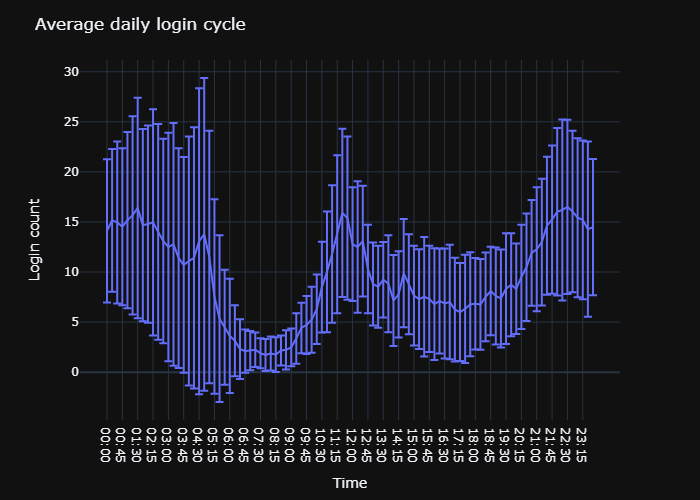

In [17]:
fig = px.line(avg_15m, x='time', y='mean', error_y='std')
fig.update_xaxes(title='Time')
fig.update_yaxes(title='Login count')
fig.update_layout(template='plotly_dark', title='Average daily login cycle')
fig.show('png')

Login count peaks around 1.30, 5.00, 12.00, and 22.30. The graph also shows a broad minimum from 6-9 am.

To get a better picture, look at the login count for each day of the week.

In [18]:
avg_15m_dayofweek = count15m.groupby(['dayofweek', 'time'], as_index=False).agg(mean=('counts', 'mean'), std=('counts', 'std'))

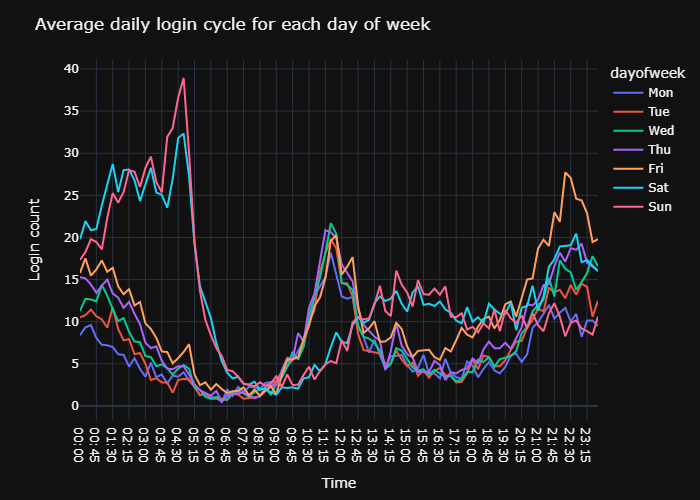

In [19]:
fig = px.line(avg_15m_dayofweek,x='time', y='mean', color='dayofweek', category_orders={'dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']})
fig.update_xaxes(title='Time')
fig.update_yaxes(title='Login count')
fig.update_layout(template='plotly_dark', title='Average daily login cycle for each day of week')
fig.show('png')

The plot shows a few interesting trends;
- Mon-Thu: Demand peaks around lunch time. Late night and early morning (21.00-5.00) activities are moderate, lowest on Monday and slowly incresing as week goes by. The login count minimizes around morning and late afternoon.
- Fri: Similar to other weekdays, except late night demand is the highest during the week suggesting people go out.
- Sat: After Friday's night, login count continues to rise and peaks around 5am (when people go home after the night out). The demand rise again during late afternoon and late night.
- Sun: Demand continues to rise after Saturday's night and peaks at 4.30am. The number picks up again late afternoon before dropping down during night time as people prepare for a new week.

Check login count for each month to see if there is any pattern.

In [20]:
avg_15m_month = count15m.groupby(['month', 'time'], as_index=False).agg(mean=('counts', 'mean'), std=('counts', 'std'))

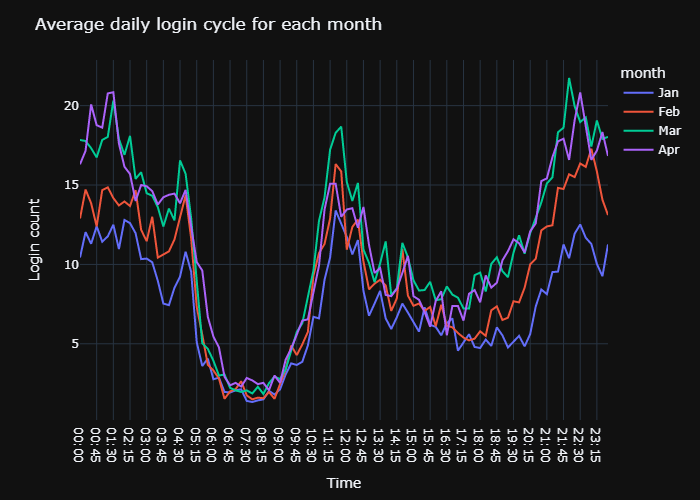

In [21]:
fig = px.line(avg_15m_month,x='time', y='mean', color='month', category_orders={'month':['Jan', 'Feb', 'Mar', 'Apr']})
fig.update_xaxes(title='Time')
fig.update_yaxes(title='Login count')
fig.update_layout(template='plotly_dark', title='Average daily login cycle for each month')
fig.show('png')

Demand is lowest in January, especially at night, and then begins to increase in subsequent months (possibly due to warmer weather).

***

# Part 2 Experiment and metrics design<a id=p2><a>

__What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?__

_Key Measure of Success_:<br>
The primary goal is to encourage driver partners to serve both cities. Therefore, the key measure of success should focus on cross-city availability and utilization.
I recommend using the percentage increase in intercity trips as the primary metric. This would be calculated as the ratio of intercity trips (toll-reimbursed) to total trips (including both intracity and intercity). <br>

_Why this metric?_ <br>
It directly reflects the success of the toll reimbursement policy in promoting cross-city service. A higher percentage indicates increased cooperation between drivers from both cities.

__Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on: <br>
a) how you will implement the experiment <br>
b) what statistical test(s) you will conduct to verify the significance of the
observation <br>
c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.__

a) Randomly select a group of driver partners (the treatment group) who will receive toll reimbursement for intercity trips. - Another group (the control group) will not receive any reimbursement. 
- Monitor both groups over a specified period (e.g., several months). 
- Clearly communicate the toll reimbursement policy to all driver partners. 
- Ensure they understand the benefits of serving both cities. 

b) Statistical Tests: 
- Hypothesis Testing: 
    - Null Hypothesis (H0): There is no significant difference in intercity trip percentages between the treatment and control groups. 
    - Alternative Hypothesis (Ha): The treatment group shows a higher intercity trip percentage than the control group. 
    - Conduct a two-sample proportion test (z-test) to compare the proportions of intercity trips. 
    - Significance Level: Set a significance level (α) to determine statistical significance (e.g., α = 0.05). 
    - Calculate Test Statistic: Compute the z-score based on the observed proportions and sample sizes. 
    - Interpretation: If the p-value is less than α, reject the null hypothesis. 
    
c) Results and Recommendations: 
- Results Interpretation: 
    - If the null hypothesis is rejected, it suggests that toll reimbursement encourages cross-city service. 
- Recommendations: 
    - If the policy is effective: 
        - Continue reimbursing toll costs. 
        - Consider additional incentives (e.g., bonuses) for intercity trips. 
    - If the policy is ineffective: 
        - Reevaluate the reimbursement amount or explore other strategies. 
- Caveats: 
    - Consider external factors (e.g., traffic conditions, seasonal variations). 
    - Monitor long-term effects beyond the experimental period.

***

# Part 3 Predictive modeling<a id=p3><a>

In [384]:
original = pd.read_json('ultimate_data_challenge.json')
original

city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   
49999         Astapor                       0  2014-01-18   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                       4.7       1.10     2014-06-17   iPhone       15.4   
1                       5.0       1.00     2014-05-05  Android        0.0   
2                       4.3       1.00     2014-01-07   iPhone        0.0   
3                       4.6       1.14     2014-06-29   iPhone       20.0   
4                       4.4       1.19     2014-03-15  Android       11.8   
...                     ...        ...            ...      ...        ...   
49995                   5.0       1.00     2014-06-05   iPhone        0.0   
49996                   NaN       1.00     2014-01-25   iPhone        0.0   
49997                   5.0       1.00     2014-05-22  Android        0.0   
49998                   3.0       1.00     2014-01-15   iPhone        0.0   
49999                   NaN       1.00     2014-04-20  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
0                     True         46.2      3.67                   5.0  
1                    False         50.0      8.26                   5.0  
2                    False        100.0      0.77                   5.0  
3                     True         80.0      2.36                   4.9  
4                    False         82.4      3.13                   4.9  
...                    ...          ...       ...                   ...  
49995                False        100.0      5.63                   4.2  
49996                False          0.0      0.00                   4.0  
49997                 True        100.0      3.86                   5.0  
49998                False        100.0      4.58                   3.5  
49999                False          0.0      3.49                   5.0  

[50000 rows x 12 columns]

In [385]:
data = original.copy()

## EDA<a id='eda'><a>

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are nulls on _avg_rating_of_driver, phone, and avg_rating_by_driver_.

In [110]:
data.describe(include=[object, bool]).T

count unique         top   freq
city                 50000      3  Winterfell  23336
signup_date          50000     31  2014-01-18   2948
last_trip_date       50000    182  2014-06-29   2036
phone                49604      2      iPhone  34582
ultimate_black_user  50000      2       False  31146

In [109]:
data.describe().T

count       mean        std  min    25%    50%  \
trips_in_first_30_days  50000.0   2.278200   3.792684  0.0   0.00   1.00   
avg_rating_of_driver    41878.0   4.601559   0.617338  1.0   4.30   4.90   
avg_surge               50000.0   1.074764   0.222336  1.0   1.00   1.00   
surge_pct               50000.0   8.849536  19.958811  0.0   0.00   0.00   
weekday_pct             50000.0  60.926084  37.081503  0.0  33.30  66.70   
avg_dist                50000.0   5.796827   5.707357  0.0   2.42   3.88   
avg_rating_by_driver    49799.0   4.778158   0.446652  1.0   4.70   5.00   

                           75%     max  
trips_in_first_30_days    3.00  125.00  
avg_rating_of_driver      5.00    5.00  
avg_surge                 1.05    8.00  
surge_pct                 8.60  100.00  
weekday_pct             100.00  100.00  
avg_dist                  6.94  160.96  
avg_rating_by_driver      5.00    5.00

There might be some outliers on _trips_in_first_30_days, avg_surge, surge_pct, and avg_dist_.	

Check distribution of these variables.

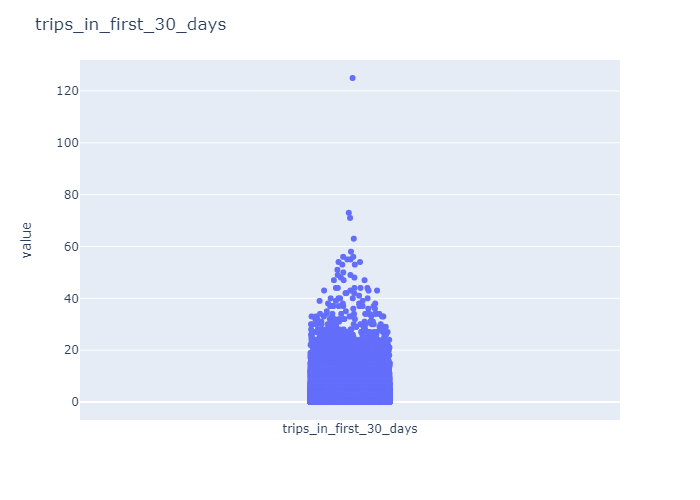

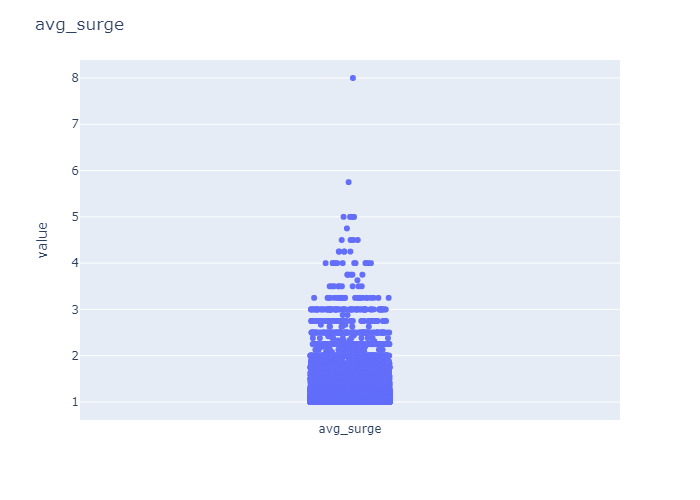

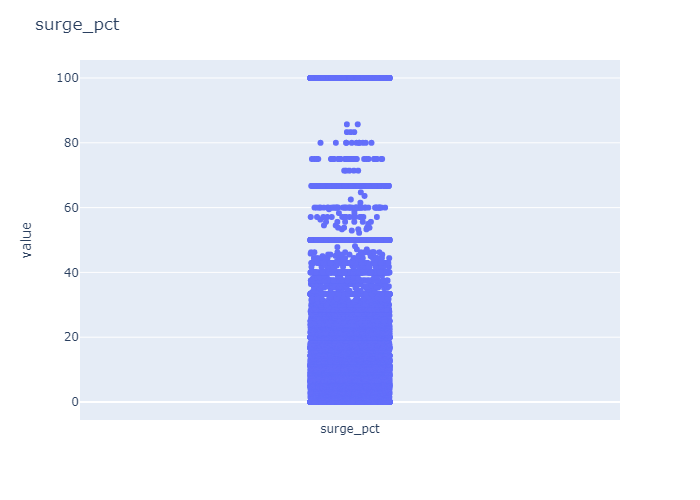

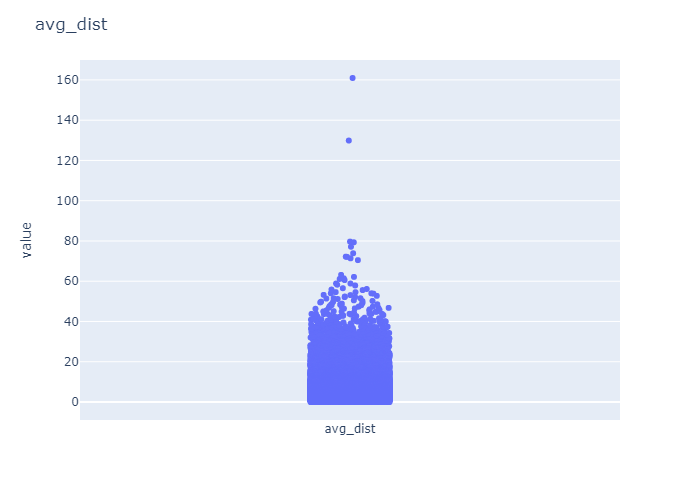

In [111]:
for col in data[['trips_in_first_30_days', 'avg_surge', 'surge_pct', 'avg_dist']].columns:
    fig = px.strip(data[col])
    fig.update_xaxes(title='')
    fig.update_layout(title=f'{col}')
    fig.show('png')

Look at data of these outiers.

In [119]:
data.nlargest(10, 'trips_in_first_30_days')

city  trips_in_first_30_days signup_date  \
18514  King's Landing                     125  2014-01-02   
99            Astapor                      73  2014-01-27   
3030       Winterfell                      71  2014-01-06   
29070         Astapor                      63  2014-01-10   
48804         Astapor                      58  2014-01-24   
36917      Winterfell                      56  2014-01-26   
45489         Astapor                      56  2014-01-28   
17942      Winterfell                      55  2014-01-07   
29043  King's Landing                      55  2014-01-22   
31047      Winterfell                      54  2014-01-25   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
18514                   5.0       1.12     2014-06-30   iPhone       14.4   
99                      4.9       1.00     2014-03-05  Android        0.0   
3030                    4.9       1.06     2014-06-28   iPhone        2.9   
29070                   4.0       1.07     2014-06-29   iPhone        7.3   
48804                   4.4       1.04     2014-06-05   iPhone        3.1   
36917                   4.8       1.01     2014-06-30   iPhone        2.2   
45489                   4.8       1.01     2014-04-23   iPhone        1.3   
17942                   4.6       1.03     2014-06-25   iPhone        5.3   
29043                   4.8       1.03     2014-06-30   iPhone        4.8   
31047                   4.9       1.10     2014-06-29   iPhone        9.1   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
18514                 True         72.0      2.02                   4.8  
99                    True         89.7      2.86                   4.9  
3030                  True         85.9      2.32                   4.8  
29070                 True         83.3      1.45                   4.6  
48804                 True         77.6      2.30                   4.7  
36917                False         73.1      3.51                   4.8  
45489                 True         78.8      3.65                   4.4  
17942                 True         68.0      3.27                   4.7  
29043                 True         66.5      3.39                   4.6  
31047                 True         83.0      2.19                   4.5

60 trips in 30 days or 2 per day seems possible, and even though 125 trips in 30 days (more than 4 per day) seems like a lot, but depending on the job of that person, it is not entirely impossible. Hence, keep them.

In [122]:
data.nlargest(10, 'avg_surge')

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
13861  Winterfell                       1  2014-01-01                   1.0   
30477  Winterfell                       1  2014-01-01                   5.0   
2817   Winterfell                       0  2014-01-02                   5.0   
19191  Winterfell                       1  2014-01-10                   5.0   
21894  Winterfell                       1  2014-01-10                   NaN   
47052  Winterfell                       1  2014-01-09                   NaN   
49383  Winterfell                       1  2014-01-10                   NaN   
1405   Winterfell                       1  2014-01-08                   5.0   
10546  Winterfell                       0  2014-01-03                   NaN   
15334  Winterfell                       0  2014-01-13                   NaN   

       avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
13861       8.00     2014-01-01   iPhone      100.0                False   
30477       5.75     2014-01-01   iPhone      100.0                False   
2817        5.00     2014-02-05   iPhone      100.0                False   
19191       5.00     2014-01-11  Android      100.0                False   
21894       5.00     2014-01-11  Android      100.0                False   
47052       5.00     2014-01-11  Android      100.0                False   
49383       5.00     2014-01-11   iPhone      100.0                False   
1405        4.75     2014-01-21   iPhone      100.0                False   
10546       4.50     2014-06-21   iPhone      100.0                False   
15334       4.50     2014-06-18   iPhone      100.0                False   

       weekday_pct  avg_dist  avg_rating_by_driver  
13861        100.0      5.77                   5.0  
30477        100.0      1.98                   5.0  
2817         100.0      3.18                   5.0  
19191        100.0      3.37                   5.0  
21894        100.0      2.46                   4.0  
47052        100.0      2.96                   5.0  
49383        100.0      2.40                   5.0  
1405         100.0      6.46                   5.0  
10546          0.0      2.70                   5.0  
15334        100.0      1.40                   5.0

Most of these customers only use the service once, maybe due to the high surge price. Interestingly, these are all in Winterfell. Keep the data.

In [123]:
data.nlargest(10, 'surge_pct')

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
28   Winterfell                       0  2014-01-19                   NaN   
32   Winterfell                       1  2014-01-05                   4.0   
34      Astapor                       1  2014-01-16                   NaN   
42   Winterfell                       1  2014-01-25                   4.0   
47   Winterfell                       1  2014-01-18                   5.0   
50   Winterfell                       0  2014-01-04                   5.0   
59      Astapor                       1  2014-01-25                   5.0   
81   Winterfell                       1  2014-01-25                   4.0   
119     Astapor                       1  2014-01-11                   NaN   
135  Winterfell                       1  2014-01-17                   NaN   

     avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
28        1.50     2014-06-08   iPhone      100.0                False   
32        2.00     2014-06-10   iPhone      100.0                False   
34        1.25     2014-01-17  Android      100.0                False   
42        1.50     2014-01-26  Android      100.0                False   
47        1.25     2014-01-19   iPhone      100.0                False   
50        1.25     2014-02-15  Android      100.0                False   
59        1.25     2014-03-29   iPhone      100.0                False   
81        3.50     2014-02-05  Android      100.0                 True   
119       2.50     2014-01-12  Android      100.0                False   
135       1.75     2014-01-18   iPhone      100.0                False   

     weekday_pct  avg_dist  avg_rating_by_driver  
28           0.0      5.97                   5.0  
32         100.0     10.01                   5.0  
34         100.0      4.12                   5.0  
42           0.0      5.72                   5.0  
47           0.0      3.61                   5.0  
50           0.0      3.25                   5.0  
59           0.0      6.05                   4.5  
81         100.0     17.89                   4.0  
119          0.0      4.14                   5.0  
135        100.0      1.99                   5.0

It is likely that there are some users who always use surge.

In [124]:
data.nlargest(10, 'avg_dist')

city  trips_in_first_30_days signup_date  \
20701         Astapor                       0  2014-01-25   
534    King's Landing                       0  2014-01-04   
1302       Winterfell                       1  2014-01-30   
22290         Astapor                       0  2014-01-12   
47595  King's Landing                       0  2014-01-25   
36625         Astapor                       2  2014-01-19   
22096         Astapor                       0  2014-01-17   
1493          Astapor                       1  2014-01-26   
19197         Astapor                       2  2014-01-17   
42835      Winterfell                       0  2014-01-10   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
20701                   NaN        1.0     2014-06-26  Android        0.0   
534                     NaN        1.0     2014-03-09     None        0.0   
1302                    5.0        1.0     2014-01-30   iPhone        0.0   
22290                   5.0        1.0     2014-06-26   iPhone        0.0   
47595                   5.0        1.0     2014-06-09   iPhone        0.0   
36625                   5.0        1.0     2014-01-22   iPhone        0.0   
22096                   NaN        1.0     2014-05-01   iPhone        0.0   
1493                    5.0        1.0     2014-01-27   iPhone        0.0   
19197                   4.7        1.0     2014-05-14   iPhone        0.0   
42835                   5.0        1.0     2014-06-28  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
20701                False        100.0    160.96                   NaN  
534                  False          0.0    129.89                   5.0  
1302                 False        100.0     79.69                   5.0  
22290                 True        100.0     79.34                   5.0  
47595                 True          0.0     77.13                   5.0  
36625                False        100.0     73.88                   3.0  
22096                 True        100.0     72.20                   5.0  
1493                 False        100.0     72.08                   5.0  
19197                 True        100.0     71.38                   5.0  
42835                False        100.0     70.48                   5.0

Even though more than 100 average mile seems unlikely, but we do not know the total number of trip the users made. Hence, it could be that the users used the service to just once. Moreover, most of these are from Astapor. Keep data.

Use ProfileReport to check for missing values and duplicates.

In [208]:
profile = ProfileReport(data, title="Profiling Report")

In [209]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Report suggest 
- 8 duplicate rows 
- 16.2% of missing values in avg rating of driver.

Drop the duplicates rows.

In [386]:
data = data.drop_duplicates()

Check for null in each column, again.

In [144]:
data.isna().mean()

city                      0.000000
trips_in_first_30_days    0.000000
signup_date               0.000000
avg_rating_of_driver      0.162406
avg_surge                 0.000000
last_trip_date            0.000000
phone                     0.007921
surge_pct                 0.000000
ultimate_black_user       0.000000
weekday_pct               0.000000
avg_dist                  0.000000
avg_rating_by_driver      0.004021
dtype: float64

0.8% and 0.4% in phone system and avg rating by driver, respectively.

Check if the missing data has any correletions with other variables.

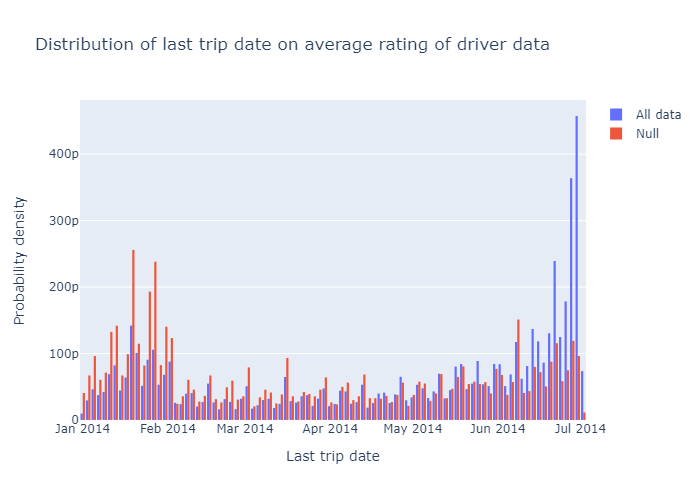

In [145]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=data.loc[data.avg_rating_of_driver.notna()].last_trip_date, histnorm='probability density', name='All data'))
fig.add_trace(go.Histogram(x=data.loc[data.avg_rating_of_driver.isna()].last_trip_date, histnorm='probability density', name='Null'))
fig.update_xaxes(title='Last trip date')
fig.update_yaxes(title='Probability density')
fig.update_layout(title='Distribution of last trip date on average rating of driver data')
fig.show('png')

Null and non-null have roughly the same distributions, but null looks more likely to churn.

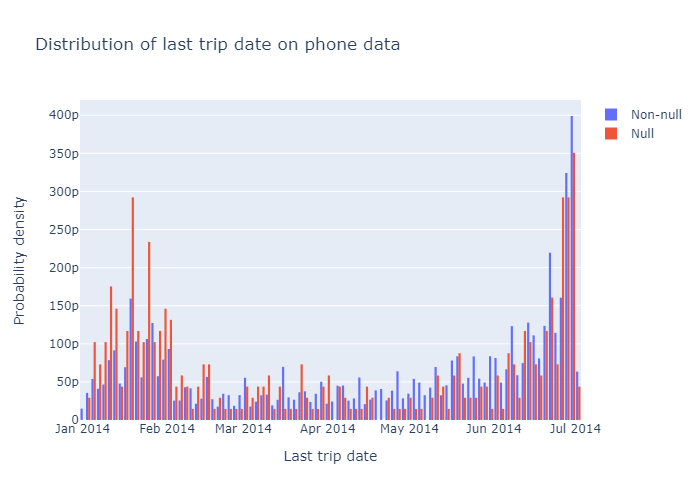

In [149]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=data.loc[data.phone.notna()].last_trip_date, histnorm='probability density', name='Non-null'))
fig.add_trace(go.Histogram(x=data.loc[data.phone.isna()].last_trip_date, histnorm='probability density', name='Null'))
fig.update_xaxes(title='Last trip date')
fig.update_yaxes(title='Probability density')
fig.update_layout(title='Distribution of last trip date on phone data')
fig.show('png')

Null and non-null data have similar distribution with null.

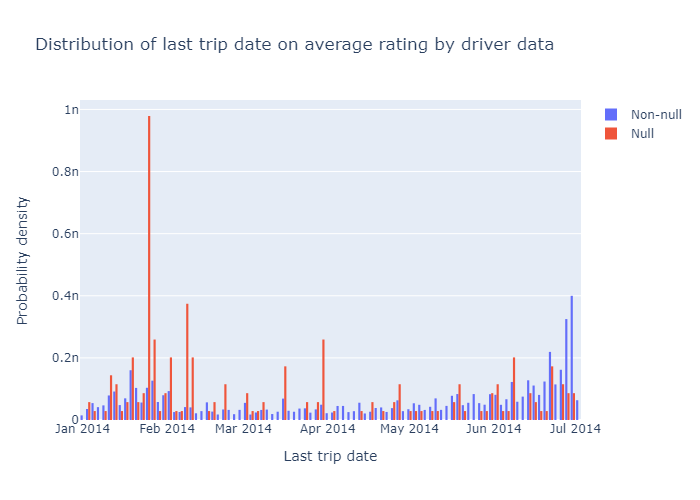

In [147]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=data.loc[data.avg_rating_by_driver.notna()].last_trip_date, histnorm='probability density', name='Non-null'))
fig.add_trace(go.Histogram(x=data.loc[data.avg_rating_by_driver.isna()].last_trip_date, histnorm='probability density', name='Null'))
fig.update_xaxes(title='Last trip date')
fig.update_yaxes(title='Probability density')
fig.update_layout(title='Distribution of last trip date on average rating by driver data')
fig.show('png')

The null data are quite sporadic indicating there is not enough null data to compare the distribution.

__What fraction of the observed users were retained?__

In [387]:
data.shape[0]/original.shape[0]

0.99984

***

Check range of signup_date

In [388]:
data.signup_date.min(), data.signup_date.max()

('2014-01-01', '2014-01-31')

Users are active if last_trip_date in June or July.

In [389]:
# active=1 , non-active=0
data = data.assign(active = [1 if (i.startswith('2014-06') | i.startswith('2014-07')) else 0 for i in data.last_trip_date])

In [390]:
data.active.mean()

0.3761401824291887

37.6% of users are active.

Check correlation with active.

In [416]:
corr = data.select_dtypes(include='number').corr('kendall')
# use kendall since correlation may not be linear and distributions are not normal
corr

trips_in_first_30_days  avg_rating_of_driver  \
trips_in_first_30_days                1.000000             -0.133249   
avg_rating_of_driver                 -0.133249              1.000000   
avg_surge                             0.210655             -0.084998   
surge_pct                             0.200628             -0.076647   
weekday_pct                          -0.030927              0.023949   
avg_dist                             -0.079136              0.037533   
avg_rating_by_driver                 -0.225850              0.180079   
active                                0.153511             -0.109168   

                        avg_surge  surge_pct  weekday_pct  avg_dist  \
trips_in_first_30_days   0.210655   0.200628    -0.030927 -0.079136   
avg_rating_of_driver    -0.084998  -0.076647     0.023949  0.037533   
avg_surge                1.000000   0.937678    -0.134280 -0.107788   
surge_pct                0.937678   1.000000    -0.138224 -0.108662   
weekday_pct             -0.134280  -0.138224     1.000000  0.068581   
avg_dist                -0.107788  -0.108662     0.068581  1.000000   
avg_rating_by_driver    -0.149968  -0.140600     0.049684  0.100042   
active                   0.220049   0.212043    -0.045731 -0.028336   

                        avg_rating_by_driver    active  
trips_in_first_30_days             -0.225850  0.153511  
avg_rating_of_driver                0.180079 -0.109168  
avg_surge                          -0.149968  0.220049  
surge_pct                          -0.140600  0.212043  
weekday_pct                         0.049684 -0.045731  
avg_dist                            0.100042 -0.028336  
avg_rating_by_driver                1.000000 -0.224376  
active                             -0.224376  1.000000

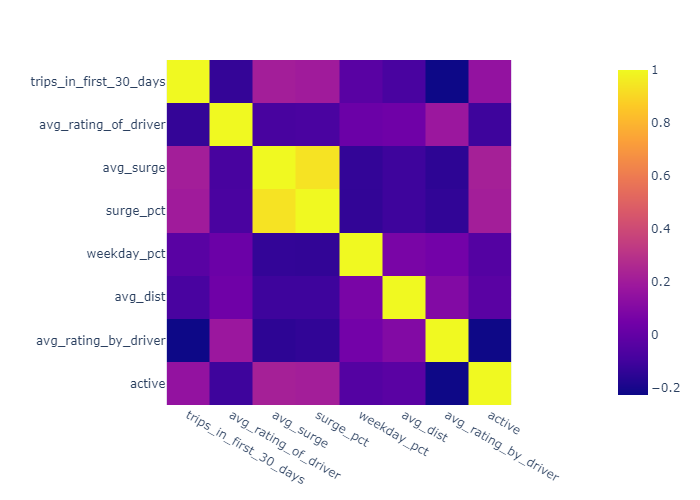

In [417]:
fig = px.imshow(corr)
fig.show('png')

No variables with high correlation with active.

Check categorical variables.

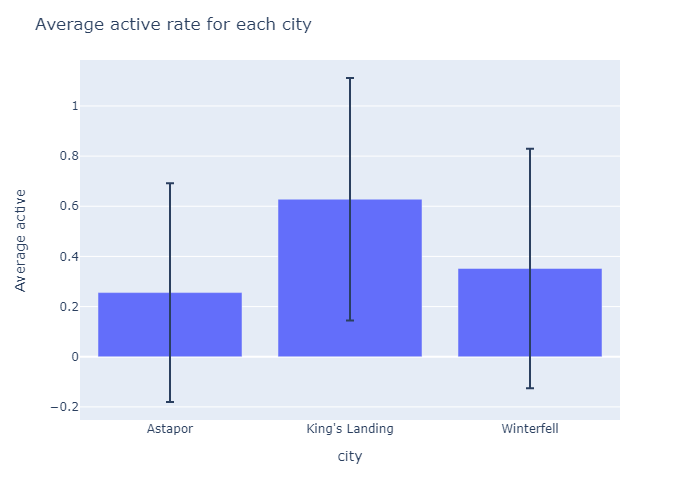

In [394]:
city = data.groupby('city', as_index=False).agg(mean=('active','mean'), std=('active','std'))
fig = px.bar(city, x='city', y='mean', error_y='std')
fig.update_yaxes(title='Average active')
fig.update_layout(title='Average active rate for each city')
fig.show('png')

King's Landing has over 60% active rate.

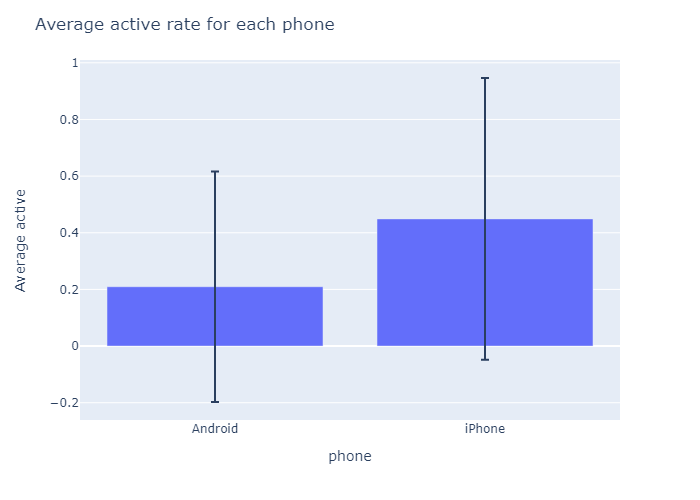

In [396]:
phone = data.groupby('phone', as_index=False).agg(mean=('active','mean'), std=('active','std'))
fig = px.bar(phone, x='phone', y='mean', error_y='std')
fig.update_yaxes(title='Average active')
fig.update_layout(title='Average active rate for each phone')
fig.show('png')

iPhone's users has more than double active rate of android's users.

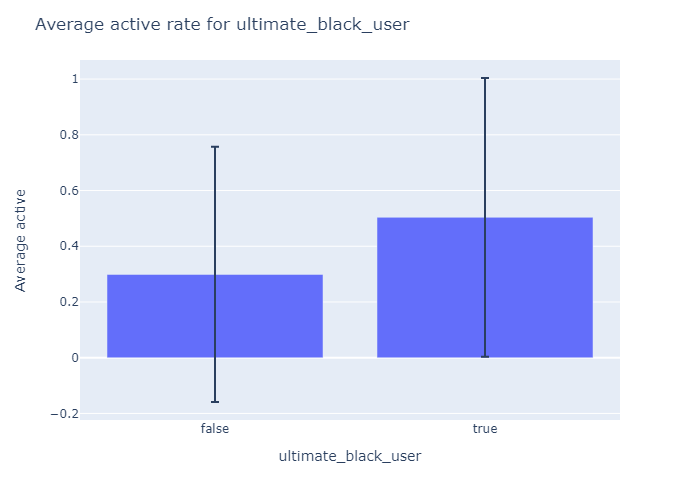

In [415]:
black = data.groupby('ultimate_black_user', as_index=False).agg(mean=('active','mean'), std=('active','std'))
fig = px.bar(black, x='ultimate_black_user', y='mean', error_y='std')
fig.update_yaxes(title='Average active')
fig.update_layout(title='Average active rate for ultimate_black_user')
fig.show('png')

If the user took an Ultimate Black in their first 30 days, they are more likely to be active.

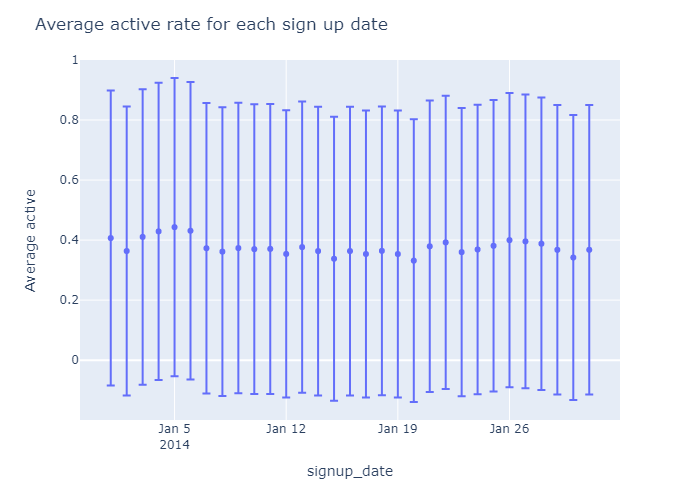

In [392]:
signup = data.groupby('signup_date', as_index=False).agg(mean=('active','mean'), std=('active','std'))
fig = px.scatter(signup, x='signup_date', y='mean', error_y='std')
fig.update_yaxes(title='Average active')
fig.update_layout(title='Average active rate for each sign up date')
fig.show('png')

Sign up date has no correlation with active.

Drop sign_up and last_trip date.

In [167]:
data = data.drop(['signup_date', 'last_trip_date'], axis=1)

***

In [170]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [178]:
kf = StratifiedKFold(n_splits=5)

## Data Transformation<a id='trans'><a>

Numerical data
- Missing data: there could be some patterns thus use KNNImputer to find nearest neighbors and impute.
- Scale data: each feature has different units and scale which will impact models, such as logistic regression.

Categorical data
- Missing data: most frequent data.
- Encoder: since there no clear order between cities or phones, use one-hot encoder.

In [255]:
numeric_features = X_train.select_dtypes(include=['number', 'bool']).columns
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer()), ("scaler", RobustScaler())]
)

categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=None, strategy='most_frequent')), 
           ("encoder", OneHotEncoder(drop='first', handle_unknown="ignore"))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Modeling<a id='model'><a>

Consider models that return coeffients or feature importance to identify key factors. Use roc_auc as a score to determine whether users are active.

Start with fast and simple linear classifier to be a benchmark.

In [397]:
steps = [('prep', preprocessor), ('sgd', SGDClassifier())]
pipeline_sgd =  Pipeline(steps)
score_sgd = cross_val_score(pipeline_sgd, X_train, y_train, scoring='roc_auc', cv=kf)
score_sgd

array([0.73441299, 0.73594797, 0.72993924, 0.73147405, 0.74044312])

Next try another linear model, logistic regression.

In [398]:
steps = [('prep', preprocessor), ('log', LogisticRegression())]
pipeline_log =  Pipeline(steps)
score_log = cross_val_score(pipeline_log, X_train, y_train, scoring='roc_auc', cv=kf)
score_log

array([0.76234663, 0.76186667, 0.75883485, 0.76202998, 0.76192591])

Slightly better. Now try an ensemble model like XGBoost

In [399]:
steps = [('prep', preprocessor), ('xgb', xgb.XGBClassifier(objective='binary:logistic'))]
pipeline_xgb =  Pipeline(steps)
score_xgb = cross_val_score(pipeline_xgb, X_train, y_train, scoring='roc_auc', cv=kf)
score_xgb

array([0.84941315, 0.85984372, 0.8500633 , 0.85431868, 0.85124598])

Much better result. Try hyperparameter optimization to improve the score.

In [400]:
def xgb_eval(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 10)
    
    xgb_param_grid = {'objective':'binary:logistic', 'n_estimators':n_estimators, 'max_depth':max_depth,
                      'learning_rate':learning_rate, 'gamma':gamma, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                      'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight}
    steps = [('prep', preprocessor), ('xgb', xgb.XGBClassifier(**xgb_param_grid))]
    pipeline =  Pipeline(steps)
    
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=kf)
    return score.mean()

In [401]:
sampler = optuna.samplers.TPESampler(seed=0)
xgb_study = optuna.create_study(direction='maximize', sampler=sampler)
xgb_study.optimize(xgb_eval, n_trials=50)

[I 2024-03-05 02:57:44,015] A new study created in memory with name: no-name-4107fb03-1f7e-4337-9b06-2f67cc47f93d
[I 2024-03-05 02:59:21,375] Trial 0 finished with value: 0.7917686540212893 and parameters: {'n_estimators': 320, 'max_depth': 15, 'learning_rate': 0.6027673484378832, 'gamma': 0.5448831829968969, 'reg_alpha': 0.4236547993389047, 'reg_lambda': 0.6458941130666561, 'subsample': 0.4432113391500656, 'colsample_bytree': 0.892855270774259, 'min_child_weight': 9.64026132896019}. Best is trial 0 with value: 0.7917686540212893.
[I 2024-03-05 03:00:36,388] Trial 1 finished with value: 0.8361937120650123 and parameters: {'n_estimators': 253, 'max_depth': 17, 'learning_rate': 0.5288996308037069, 'gamma': 0.5680445610939323, 'reg_alpha': 0.925596638292661, 'reg_lambda': 0.07103605819788694, 'subsample': 0.09625800670452529, 'colsample_bytree': 0.03001621346592246, 'min_child_weight': 8.342936470924586}. Best is trial 1 with value: 0.8361937120650123.
[I 2024-03-05 03:02:01,564] Trial 2 

[I 2024-03-05 03:25:46,498] Trial 19 finished with value: 0.8350367649383641 and parameters: {'n_estimators': 459, 'max_depth': 10, 'learning_rate': 0.2252619711172087, 'gamma': 0.930054749667052, 'reg_alpha': 0.8179977340345128, 'reg_lambda': 0.701041020476274, 'subsample': 0.7311163115957792, 'colsample_bytree': 0.500462110832199, 'min_child_weight': 3.852200184366483}. Best is trial 11 with value: 0.8581981807645256.
[I 2024-03-05 03:27:38,506] Trial 20 finished with value: 0.7899437697758215 and parameters: {'n_estimators': 368, 'max_depth': 13, 'learning_rate': 0.8347973465003669, 'gamma': 0.11795371213588804, 'reg_alpha': 0.5747978880037141, 'reg_lambda': 0.8913101237866771, 'subsample': 0.5475703012443847, 'colsample_bytree': 0.7930967408840521, 'min_child_weight': 1.6900772082405997}. Best is trial 11 with value: 0.8581981807645256.
[I 2024-03-05 03:29:00,899] Trial 21 finished with value: 0.853152570170605 and parameters: {'n_estimators': 396, 'max_depth': 7, 'learning_rate': 

[I 2024-03-05 03:57:26,191] Trial 39 finished with value: 0.84501692750252 and parameters: {'n_estimators': 417, 'max_depth': 8, 'learning_rate': 0.14391774077487868, 'gamma': 0.4768502665270468, 'reg_alpha': 0.7970041831341421, 'reg_lambda': 0.7927823654843578, 'subsample': 0.3769578857668207, 'colsample_bytree': 0.39207593065639046, 'min_child_weight': 2.6566592015985764}. Best is trial 11 with value: 0.8581981807645256.
[I 2024-03-05 03:58:47,348] Trial 40 finished with value: 0.7920680537628044 and parameters: {'n_estimators': 351, 'max_depth': 6, 'learning_rate': 0.48332932386649474, 'gamma': 0.5263740511993771, 'reg_alpha': 0.8902666721336772, 'reg_lambda': 0.37244284617345114, 'subsample': 0.20883662114386425, 'colsample_bytree': 0.6134496356568508, 'min_child_weight': 1.3245966112569405}. Best is trial 11 with value: 0.8581981807645256.
[I 2024-03-05 04:00:08,606] Trial 41 finished with value: 0.8485245544652023 and parameters: {'n_estimators': 450, 'max_depth': 4, 'learning_ra

In [402]:
best_trial = xgb_study.best_trial
best_params = best_trial.params
best_params['objective'] = 'binary:logistic'

In [403]:
best_params

{'n_estimators': 397,
 'max_depth': 8,
 'learning_rate': 0.030395893426108114,
 'gamma': 0.3225572001024039,
 'reg_alpha': 0.6652515532038727,
 'reg_lambda': 0.9244940335097857,
 'subsample': 0.9792654490918004,
 'colsample_bytree': 0.3638251166083611,
 'min_child_weight': 0.1554085981528477,
 'objective': 'binary:logistic'}

Check if feature selection can provide better score.

In [404]:
steps = [('prep', preprocessor), ('selectkbest', SelectKBest(mutual_info_classif)), ('xgb', xgb.XGBClassifier(**best_params))]
pipeline =  Pipeline(steps)
k = [k for k in range(1, X_train.shape[1]+2)]
parameters = {'selectkbest__k':k}
xgb_mi_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', cv=kf)
xgb_mi_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_r...
                                                      learning_rate=0.030395893426108114,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=8,
                                                      max_leaves=None,
                                                      min_child_weight=0.1554085981528477,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=397,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             scoring='roc_auc')

In [405]:
xgb_mi_cv.best_score_, xgb_mi_cv.best_params_

(0.8581981807645256, {'selectkbest__k': 11})

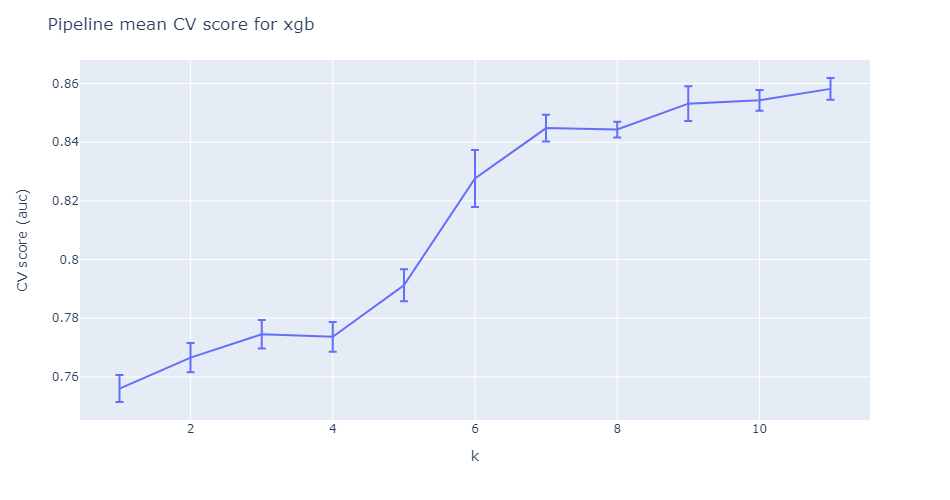

In [406]:
score_mean = xgb_mi_cv.cv_results_['mean_test_score']
score_std = xgb_mi_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb',
                  yaxis_title='CV score (auc)', width=950, height=500)

fig.show('png')

Score increases with larger k.

In [407]:
idx = xgb_mi_cv.best_estimator_.named_steps.selectkbest.get_support()

In [408]:
importances = xgb_mi_cv.best_estimator_.named_steps.xgb.feature_importances_
importance_xgb_mi = pd.DataFrame({'feature': xgb_mi_cv.best_estimator_.named_steps.prep.get_feature_names_out()[idx], 
                              'importance': importances})
importance_xgb_mi.feature = importance_xgb_mi.feature.str.replace('.*__','', regex=True)
top_xgb_mi = importance_xgb_mi.sort_values('importance', ascending=False)
top_xgb_mi

feature  importance
8      city_King's Landing    0.492587
4      ultimate_black_user    0.188088
10            phone_iPhone    0.160515
7     avg_rating_by_driver    0.033436
9          city_Winterfell    0.030605
5              weekday_pct    0.027875
3                surge_pct    0.026878
0   trips_in_first_30_days    0.016793
2                avg_surge    0.010240
6                 avg_dist    0.006669
1     avg_rating_of_driver    0.006314

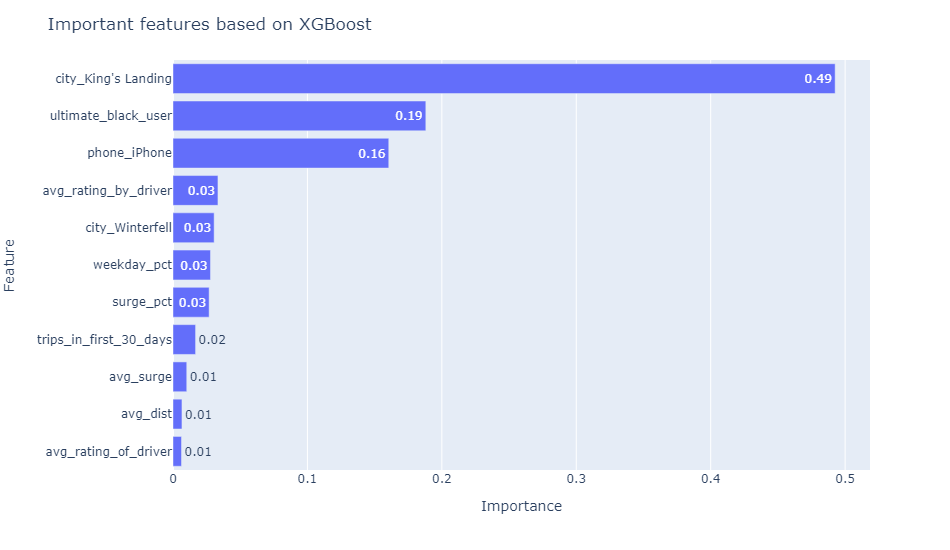

In [409]:
fig = px.bar(x=top_xgb_mi.importance[::-1], y=top_xgb_mi.feature[::-1], text_auto='.2f', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('png')

According to the model, The most importance features are city_King's Landing, ultimate_black_user, and phone_iPhone, in agreement with the EDA. 

__Ultimate might leverage the insights gained from the model to improve its long term rider retention by__
- Identify users who fit the criteria (live in King’s Landing, use black Ultimate service within the first 30 days, and use iPhones). Tailor personalized messages to encourage continued engagement.
- Send relevant notifications to these users. For example, offer exclusive promotions, loyalty rewards, or updates related to their preferred service.
- Recognize and reward these users. Provide priority access to drivers, faster pickups, or premium support.
- Offer curated experiences based on their preferences. For instance, suggest popular destinations in King’s Landing or recommend black Ultimate rides during peak hours.
- Encourage users to subscribe to Ultimate packages. Highlight the benefits, such as fixed pricing, no surge fees, and priority availability.
- Provide discounts or additional perks for subscribing within the first 30 days.

For users who do not fit the profile ultimate may improve their retention by
- Offer occasional discounts, promo codes, or special deals to all users. Encourage them to use the service more frequently.
- Regularly collect feedback from all users. Understand pain points, preferences, and areas for improvement. 
- Introduce additional services (e.g., carpooling, shared rides, delivery services) to cater to different needs.
- Offer tiered membership levels (e.g., bronze, silver, gold) based on usage. Higher tiers unlock exclusive benefits.
- Send targeted reactivation offers or personalized emails or notifications inviting them to try the service again.

In [410]:
y_pred = xgb_mi_cv.best_estimator_.predict(X_test)
y_prob = xgb_mi_cv.best_estimator_.predict_proba(X_test)

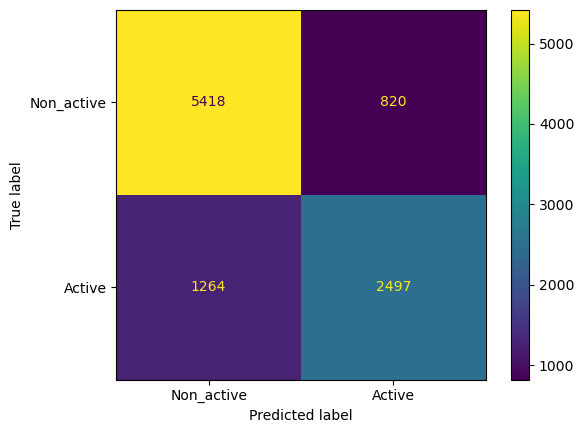

In [411]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non_active', 'Active'])
cmd.plot()
plt.show()

In [412]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6238
           1       0.75      0.66      0.71      3761

    accuracy                           0.79      9999
   macro avg       0.78      0.77      0.77      9999
weighted avg       0.79      0.79      0.79      9999



In [439]:
fpr, tpr, _ = roc_curve(y_test, y_prob.T[1])
roc_auc = auc(fpr, tpr)
prec, recall, thresholds = precision_recall_curve(y_test, y_prob.T[1])
average_precision=average_precision_score(y_test, y_prob.T[1])
f1 = f1_score(y_test,y_pred)

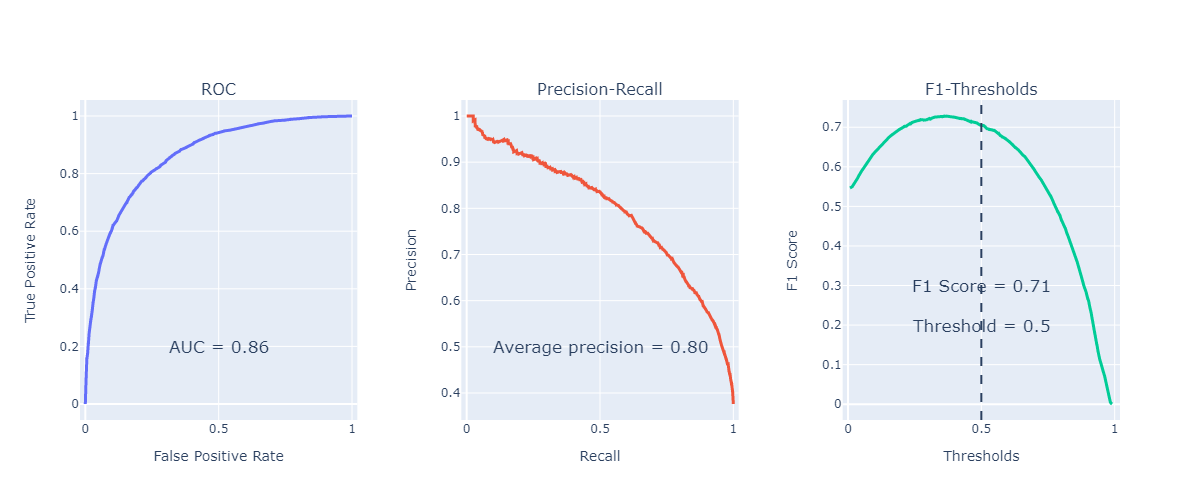

In [444]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("ROC", "Precision-Recall", 'F1-Thresholds'), 
                    horizontal_spacing=0.1)

fig.append_trace(go.Scatter(x=fpr, y=tpr, mode='lines', line={'width':3}), row=1, col=1)
fig.update_xaxes(title_text="False Positive Rate", range=[-0.02,1.02], row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
fig.add_annotation(x=0.5, y=0.2, text=f'AUC = {roc_auc:.2f}', showarrow=False,  font={'size':17}, row=1, col=1)

fig.add_trace(go.Scatter(x=recall, y=prec, mode='lines', line={'width':3}), row=1, col=2)
fig.update_xaxes(title_text="Recall", range=[-0.02,1.02], row=1, col=2)
fig.update_yaxes(title_text="Precision", row=1, col=2)
fig.add_annotation(x=0.5, y=0.5, text=f'Average precision = {average_precision:.2f}', showarrow=False,  font={'size':17}, row=1, col=2)

fig.add_trace(go.Scatter(x=thresholds, y=2*prec[:-1]*recall[:-1]/(prec[:-1]+recall[:-1]), mode='lines', line={'width':3}), row=1, col=3)
fig.update_xaxes(title_text="Thresholds", range=[-0.02,1.02], row=1, col=3)
fig.update_yaxes(title_text="F1 Score", row=1, col=3)
fig.add_vline(x=0.5, line_width=2, line_dash="dash", row=1, col=3)
fig.add_annotation(x=0.5, y=0.3, text=f'F1 Score = {f1:.2f}', showarrow=False,  font={'size':17}, row=1, col=3)
fig.add_annotation(x=0.5, y=0.2, text=f'Threshold = 0.5', showarrow=False,  font={'size':17}, row=1, col=3)

fig.update_layout(showlegend=False,
                  template='plotly',
                  width=1200, height=500)
fig.show('png')

The goal of this model is to distinguish between positive (active) and negative (non-active) classes, and it performs quite well in that regard as can be seen from auc of 0.86. 

However, if the goal is to focus on getting the most accurate number of active users then this model does not perform very well as the average precision and f1 score are not very high.

Note that the given data set does not contain frequency of the trip which could be a key factor in predicting active users.